[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/intro.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow

------------------
## Intro to pzflow

This notebook demonstrates building a normalizing flow with `pzflow` to learn the joint probability distribution of some 2-D data.

You do not need to have any previous knowledge of normalizing flows to get started with `pzflow`, however if you are interested, here are some good sources:
- Eric Jang's tutorial: [part 1](https://blog.evjang.com/2018/01/nf1.html), [part 2](https://blog.evjang.com/2018/01/nf2.html)
- [Here](https://github.com/janosh/awesome-normalizing-flows)  is a comprehensive list of papers, blogs, videos, and packages
- Two good intro papers using Coupling Layers: [NICE](http://arxiv.org/abs/1605.08803), [Real NVP](http://arxiv.org/abs/1605.08803)
- The paper on [Neural Spline Couplings](https://arxiv.org/abs/1906.04032)

In [1]:
from pzflow import Flow
from pzflow.bijectors import RollingSplineCoupling, Chain, Scale
from pzflow.examples import two_moons_data

import jax.numpy as np
import matplotlib.pyplot as plt

First let's load some example data. It's the familiar two moons data set from scikit-learn, loaded in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

In [2]:
data = two_moons_data()
data

,x,y
0,-1.026942,1.410649
1,0.814149,-1.365693
2,1.718791,0.362482
3,0.677510,-1.685869
4,1.060328,-1.363168
...,...,...
9995,-1.121514,1.657424
9996,-0.994531,1.445759
9997,1.170882,-1.276065
9998,1.061871,-1.318802


Let's plot it to see what it looks like.

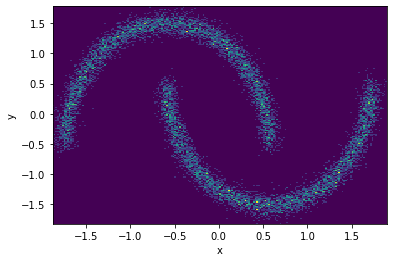

In [3]:
plt.hist2d(data['x'], data['y'], bins=200)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now let's build a normalizing flow.
We will use the `Flow` object, which requires two things:
1. the names of the columns in our data set
2. a bijector

The bijector I recommend "out-of-the-box" is the Rolling Spline Coupling, a bijector that alternates [Neural Spline Couplings](https://arxiv.org/abs/1906.04032) and "Rolling" layers. It has 5 parameters:
- `nlayers` - The number of (Neural Spline, Roll()) couplets in the chain of bijectors
- `K` - The number of bins in the splines
- `B` - The range of the splines
- `hidden_layers` - the number of hidden layers in the neural network that calculates the spline bins and derivatives
- `hidden_dim` - the number of hidden dimensions in that same neural network

Only `nlayers` is required.
For this example, we will set `nlayers` = 2 to match the dimension of our data. This ensures that both the $x$ and $y$ dimensions get transformed. Feel free to play around with changing the other parameters. 

*Note: see the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb) for an example of constructing a more complicated bijector*

In [4]:
# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# create the bijector
bijector = RollingSplineCoupling(nlayers=nlayers)

# create the normalizing flow
flow = Flow(data.columns, bijector)

Now we can train our normalizing flow.
This is as simple as calling `flow.train(data)`.
There are several training parameters you can set, including the number of epochs, the batch size, the optimizer, and the random seed.
See the documentation for the normalizing flow for more details.
For this example, let's use the defaults, but set `verbose=True` so that training losses are printed throughout the training process.

In [5]:
%%time
losses = flow.train(data, verbose=True)

Training 50 epochs 
Loss:
(0) 2.7930
(1) 2.4776
(3) 2.0141
(5) 1.6958
(7) 1.6304
(9) 1.5129
(11) 1.4235
(13) 1.3893
(15) 1.3501
(17) 1.3283
(19) 1.3193
(21) 1.2925
(23) 1.2757
(25) 1.2988
(27) 1.2948
(29) 1.2510
(31) 1.2334
(33) 1.2507
(35) 1.2269
(37) 1.2207
(39) 1.2225
(41) 1.2270
(43) 1.2148
(45) 1.2406
(47) 1.2053
(49) 1.2312
(50) 1.1996
CPU times: user 3min 24s, sys: 15min 26s, total: 18min 51s
Wall time: 33.6 s


Now let's plot the training losses to make sure everything looks like we expect it to...

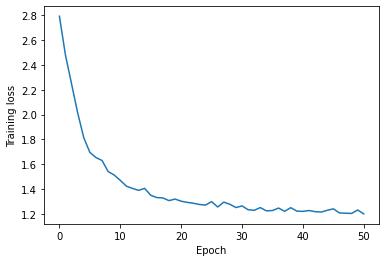

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Perfect!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make another histogram to see if it matches the data.

In [7]:
samples = flow.sample(10000, seed=0)

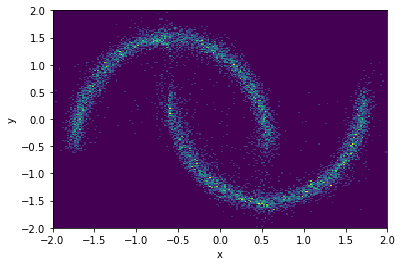

In [8]:
plt.hist2d(samples['x'], samples['y'], bins=200, range=((-2,2),(-2,2)))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Looks great!

We can also use the flow to calculate redshift posteriors using the `posterior` method. We need to provide the name of the column we want to calculate a posterior for, as well as a grid on which to calculate the posterior.

In [9]:
grid = np.arange(-2, 2.02, 0.02)
pdfs = flow.posterior(data, column="x", grid=grid)

Let's plot the first posterior.

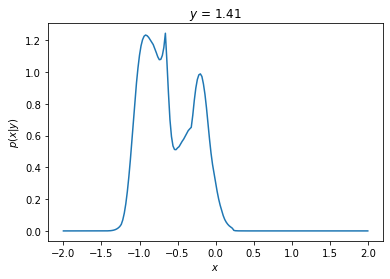

In [10]:
plt.plot(grid, pdfs[0])
plt.title(f"$y$ = {data['y'][0]:.2f}")
plt.xlabel("$x$")
plt.ylabel("$p(x|y)$")
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [11]:
import pzflow
flow.info = f"""
This is an example flow, trained on 100,000 points from the scitkit-learn
two moons data set.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import two_moons_data
>>> data = two_moons_data()

This flow was created with pzflow version {pzflow.__version__}
"""

In [12]:
print(flow.info)


This is an example flow, trained on 100,000 points from the scitkit-learn
two moons data set.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import two_moons_data
>>> data = two_moons_data()

This flow was created with pzflow version 1.7.0



Now let's save the flow to a file that can be loaded later:

In [13]:
flow.save("example-flow.pkl")

This file can be loaded on Flow instantiation:

In [14]:
flow = Flow(file="example-flow.pkl")